<a href="https://colab.research.google.com/github/Ciss48/Revenue-Function-by-Winrate/blob/main/Winrate_Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

project_id = 'crazy-coffee-jam'

from google.colab import auth
auth.authenticate_user()
# Construct a BigQuery client object.
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

# Winrate vs Droprate

In [ ]:
# Winrate vs
query1 = """
WITH start_events AS (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_start,
    COUNT( DISTINCT user_pseudo_id) as user_start
  FROM `crazy-coffee-jam.flatten_table.start_level`
  where event_date between '2025-05-01' and '2025-05-31'
  and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date >= '2025-05-01')
  and version in ('1.0.11','1.0.7')
  GROUP BY  level
),
win_events AS (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_win,
    COUNT( DISTINCT user_pseudo_id) as user_win
  FROM `crazy-coffee-jam.flatten_table.win_level`
  where event_date between '2025-05-01' and '2025-05-31'
  and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date >= '2025-05-01')
  and version in ('1.0.11','1.0.7')
  GROUP BY  level
),
lose_events AS (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_lose,
    COUNT( DISTINCT user_pseudo_id) as user_lose
  FROM `crazy-coffee-jam.flatten_table.lose_level`
  where event_date between '2025-05-01' and '2025-05-31'
  and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date >= '2025-05-01')
  and version in ('1.0.11','1.0.7')
  GROUP BY  level
),
revive_events as (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_revive,
    COUNT( DISTINCT user_pseudo_id) as user_revive
  FROM `crazy-coffee-jam.flatten_table.revive_level`
  where event_date between '2025-05-01' and '2025-05-31'
  and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date >= '2025-05-01')
  and version in ('1.0.11','1.0.7')
  GROUP BY  level
)
select
  safe_cast(s.level as int) as level,
  s.event_start,
  s.user_start,
  COALESCE(w.event_win, 0) as event_win,
  COALESCE(l.event_lose, 0) as event_lose,
  COALESCE(r.event_revive, 0) as event_revive
from start_events s
left join win_events w on s.level = w.level
left join lose_events l on s.level = l.level
left join revive_events r on s.level = r.level
"""
winrate = client.query(query1).to_dataframe()

winrate = winrate.sort_values('level', ascending=True)

In [ ]:
winrate[winrate['level'] == 80]

,level,event_start,user_start,event_win,event_lose,event_revive
62,80,1306,1001,1015,129,483


In [ ]:
# Điền các giá trị 0 vào các ô NA
winrate = winrate.fillna(0)

# tạo df chứa app_remove và arpu by level
query = """
with a as (
select level, sum(total_revenue) as total_revenue
from `crazy-coffee-jam.dashboard_table.arpu_level`
where event_date between '2025-05-01' and '2025-05-31'
and version in ('1.0.11','1.0.7')
group by level
), b as (
select level, sum(num_user_remove) as num_user_remove
from `crazy-coffee-jam.dashboard_table.remove_by_level`
where event_date between '2025-05-01' and '2025-05-31'
and version in ('1.0.11','1.0.7')
group by level
)
select a.level, a.total_revenue, b.num_user_remove
from a left join b on a.level = b.level;
"""
arpu_remove = client.query(query).to_dataframe()
arpu_remove = arpu_remove.fillna(0)
arpu_remove = arpu_remove.sort_values('level', ascending=True)

# Nối 2 df qua level
df = winrate.merge(arpu_remove, on='level', how='left')
df

,level,event_start,user_start,event_win,event_lose,event_revive,total_revenue,num_user_remove
0,1,25756,24141,24441,3,0,112.456390,606
1,2,24305,23220,23927,1,0,40.085374,247
2,3,23877,22871,23591,0,0,34.167037,261
3,4,23617,22549,23135,3,2,44.283271,429
4,5,23431,22056,22046,3,2,1359.456198,2118
...,...,...,...,...,...,...,...,...
1458,1460,1,1,1,0,0,0.008829,0
1459,1461,1,1,1,0,0,0.003192,0
1460,1462,1,1,1,0,0,0.003250,0
1461,1463,1,1,1,0,0,0.002793,0


In [ ]:
# Transform and add column
# Add next level's user_start count
df['user_start_next_level'] = df['user_start'].shift(-1)

# Calculate drop rate
df['drop_user'] = 1 - (df['user_start_next_level'] / df['user_start'])

# Calculate winrate
df['winrate'] = df['event_win'] / (df['event_win'] + df['event_lose'] + df['event_revive'])
df['arpu'] = df['total_revenue'] / df['user_start']
df = df[df['level'] <= 80]
df

,level,event_start,user_start,event_win,event_lose,event_revive,total_revenue,num_user_remove,user_start_next_level,drop_user,winrate,arpu
0,1,25756,24141,24441,3,0,112.456390,606,23220,0.038151,0.999877,0.004658
1,2,24305,23220,23927,1,0,40.085374,247,22871,0.01503,0.999958,0.001726
2,3,23877,22871,23591,0,0,34.167037,261,22549,0.014079,1.0,0.001494
3,4,23617,22549,23135,3,2,44.283271,429,22056,0.021863,0.999784,0.001964
4,5,23431,22056,22046,3,2,1359.456198,2118,19063,0.1357,0.999773,0.061637
...,...,...,...,...,...,...,...,...,...,...,...,...
75,76,1098,1025,1049,17,264,40.606540,0,1028,-0.002927,0.788722,0.039616
76,77,1611,1028,1045,147,483,50.080687,2,1014,0.013619,0.623881,0.048717
77,78,1271,1014,1027,105,565,50.122129,3,1001,0.012821,0.605186,0.04943
78,79,1356,1001,1020,181,588,42.197144,0,1001,0.0,0.570151,0.042155


In [ ]:
# prompt: Sử dụng dataframe df: in drop_ủser column, change all value < 0 to 0

# Change all values < 0 in the 'drop_user' column to 0
df['drop_user'] = df['drop_user'].apply(lambda x: 0 if x < 0 else x)

<ipython-input-60-3d926de20841>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_train = df[['level', 'winrate','drop_user']]
df_train

,level,winrate,drop_user
0,1,0.999877,0.038151
1,2,0.999958,0.015030
2,3,1.0,0.014079
3,4,0.999784,0.021863
4,5,0.999773,0.135700
...,...,...,...
75,76,0.788722,0.000000
76,77,0.623881,0.013619
77,78,0.605186,0.012821
78,79,0.570151,0.000000


## Model to find function

In [ ]:
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Prepare data
X = df_train[['winrate', 'level']]
y = df_train['drop_user']

# Try different models,
models = {
    'Linear Regression': LinearRegression(),
    'Polynomial Regression': make_pipeline(PolynomialFeatures(4), LinearRegression()),
    'SVR (RBF kernel)': SVR(kernel='rbf', C=80, gamma='auto'),
    'Decision Tree': DecisionTreeRegressor(max_depth=5),
    'XGBoost': XGBRegressor(max_depth=2, learning_rate=0.1)
}

# Fit and evaluate each model,
for name, model in models.items():
    model.fit(X, y)
    y_pred = model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f'\n{name}:')
    print(f'MAE: {mae:.6f}')
    print(f'R2 Score: {r2:.6f}')



Linear Regression:
MAE: 0.019546
R2 Score: 0.574543

Polynomial Regression:
MAE: 0.011919
R2 Score: 0.801895

SVR (RBF kernel):
MAE: 0.064815
R2 Score: -2.019748

Decision Tree:
MAE: 0.006063
R2 Score: 0.934490

XGBoost:
MAE: 0.006487
R2 Score: 0.953441


In [ ]:
# Use the best performing model for visualization,
best_model = models['Polynomial Regression']  # Change this based on result

# Create meshgrid for 3D surface,
win_rate_range = np.linspace(df_train['winrate'].min(), df_train['winrate'].max(), 80)
level_range = np.linspace(1, 80, 80)
win_rate_mesh, level_mesh = np.meshgrid(win_rate_range, level_range)

# Prepare mesh points for prediction,
mesh_points = np.column_stack((win_rate_mesh.ravel(), level_mesh.ravel()))
z = best_model.predict(mesh_points).reshape(win_rate_mesh.shape)

# Create 3D plot with plotly,
import plotly.graph_objects as go

# Create the surface,
surface = go.Surface(
    x=win_rate_mesh,
    y=level_mesh,
    z=z,
    colorscale='viridis',
    opacity=0.8,
    name='Regression Surface'
)

# Create scatter points for actual data,
actual_data = df_train.copy()
scatter = go.Scatter3d(
    x=actual_data['winrate'],
    y=actual_data['level'],
    z=actual_data['drop_user'],
    mode='markers',
    marker=dict(
        size=4,
        color='red',
        opacity=0.6
    ),
    name='Actual Data'
)

# Create the figure and add traces,
fig = go.Figure(data=[surface, scatter])

# Update layout
fig.update_layout(
    title='3D Regression Surface',
    scene=dict(
        xaxis_title='Win Rate',
        yaxis_title='Level',
        zaxis_title='Drop Rate'
    ),
    width=1000,
    height=800
)

fig.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but PolynomialFeatures was fitted with feature names



In [ ]:
# After fitting the model,
poly_model = models['Polynomial Regression']
poly_features = poly_model.named_steps['polynomialfeatures']
linear_model = poly_model.named_steps['linearregression']

# Get the feature names,
feature_names = poly_features.get_feature_names_out(['winrate', 'level'])

# Get the coefficients and intercept,
coefficients = linear_model.coef_
intercept = linear_model.intercept_

# Print the function,
print("Drop Rate =", end=" ")
print(f"{intercept:.6f}", end="")
for coef, feature in zip(coefficients, feature_names):
    if coef != 0:
        print(f" + ({coef:.6f} × {feature})", end="")

Drop Rate = 0.418740 + (-0.157176 × winrate) + (-0.005312 × level) + (0.638253 × winrate^2) + (-0.036431 × winrate level) + (0.000002 × level^2) + (-1.586375 × winrate^3) + (0.053189 × winrate^2 level) + (0.000205 × winrate level^2) + (0.000002 × level^3) + (0.738328 × winrate^4) + (-0.010917 × winrate^3 level) + (-0.000351 × winrate^2 level^2) + (0.000001 × winrate level^3) + (-0.000000 × level^4)

# Winrate vs Arpu

In [ ]:
df_train = df[['level', 'winrate','arpu']]
df_train

,level,winrate,arpu
0,1,0.999877,0.004658
1,2,0.999958,0.001726
2,3,1.0,0.001494
3,4,0.999784,0.001964
4,5,0.999773,0.061637
...,...,...,...
75,76,0.788722,0.039616
76,77,0.623881,0.048717
77,78,0.605186,0.04943
78,79,0.570151,0.042155


In [ ]:
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Prepare data
X = df_train[['winrate', 'level']]
y = df_train['arpu']

# Try different models,
models = {
    'Linear Regression': LinearRegression(),
    'Polynomial Regression': make_pipeline(PolynomialFeatures(4), LinearRegression()),
    'SVR (RBF kernel)': SVR(kernel='rbf', C=100, gamma='auto'),
    'Decision Tree': DecisionTreeRegressor(max_depth=5),
    'XGBoost': XGBRegressor(max_depth=2, learning_rate=0.1)
}

# Fit and evaluate each model,
for name, model in models.items():
    model.fit(X, y)
    y_pred = model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f'\n{name}:')
    print(f'MAE: {mae:.6f}')
    print(f'R2 Score: {r2:.6f}')



Linear Regression:
MAE: 0.011870
R2 Score: 0.746180

Polynomial Regression:
MAE: 0.008509
R2 Score: 0.862639

SVR (RBF kernel):
MAE: 0.038106
R2 Score: -1.049839

Decision Tree:
MAE: 0.003622
R2 Score: 0.959218

XGBoost:
MAE: 0.004770
R2 Score: 0.953396


In [ ]:
# Use the best performing model for visualization,
best_model = models['Polynomial Regression']  # Change this based on result

# Create meshgrid for 3D surface,
win_rate_range = np.linspace(df_train['winrate'].min(), df_train['winrate'].max(), 80)
level_range = np.linspace(1, 80, 80)
win_rate_mesh, level_mesh = np.meshgrid(win_rate_range, level_range)

# Prepare mesh points for prediction,
mesh_points = np.column_stack((win_rate_mesh.ravel(), level_mesh.ravel()))
z = best_model.predict(mesh_points).reshape(win_rate_mesh.shape)

# Create 3D plot with plotly,
import plotly.graph_objects as go

# Create the surface,
surface = go.Surface(
    x=win_rate_mesh,
    y=level_mesh,
    z=z,
    colorscale='viridis',
    opacity=0.8,
    name='Regression Surface'
)

# Create scatter points for actual data,
actual_data = df_train.copy()
scatter = go.Scatter3d(
    x=actual_data['winrate'],
    y=actual_data['level'],
    z=actual_data['arpu'],
    mode='markers',
    marker=dict(
        size=4,
        color='red',
        opacity=0.6
    ),
    name='Actual Data'
)

# Create the figure and add traces,
fig = go.Figure(data=[surface, scatter])

# Update layout
fig.update_layout(
    title='3D Regression Surface',
    scene=dict(
        xaxis_title='Win Rate',
        yaxis_title='Level',
        zaxis_title='ARPU'
    ),
    width=1000,
    height=800
)

fig.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but PolynomialFeatures was fitted with feature names



In [ ]:
# After fitting the model,
poly_model = models['Polynomial Regression']
poly_features = poly_model.named_steps['polynomialfeatures']
linear_model = poly_model.named_steps['linearregression']

# Get the feature names,
feature_names = poly_features.get_feature_names_out(['winrate', 'level'])

# Get the coefficients and intercept,
coefficients = linear_model.coef_
intercept = linear_model.intercept_

# Print the function,
print("ARPU =", end=" ")
print(f"{intercept:.6f}", end="")
for coef, feature in zip(coefficients, feature_names):
    if coef != 0:
        print(f" + ({coef:.6f} × {feature})", end="")

ARPU = -0.311645 + (1.570036 × winrate) + (0.024155 × level) + (-2.905042 × winrate^2) + (-0.055490 × winrate level) + (-0.000513 × level^2) + (2.510394 × winrate^3) + (0.056066 × winrate^2 level) + (0.000435 × winrate level^2) + (0.000006 × level^3) + (-0.857214 × winrate^4) + (-0.020626 × winrate^3 level) + (-0.000166 × winrate^2 level^2) + (-0.000002 × winrate level^3) + (-0.000000 × level^4)

# Function Optimize Revenue

In [ ]:
def compute_drop_rate(winrate, level):
    """
    Calculates the drop rate based on winrate and level using a polynomial function.
    """
    drop_rate = (
        0.418740 +
        (-0.157176 * winrate) +
        (-0.005312 * level) +
        (0.638253 * winrate**2) +
        (-0.036431 * winrate * level) +
        (0.000002 * level**2) +
        (-1.586375 * winrate**3) +
        (0.053189 * winrate**2 * level) +
        (0.000205 * winrate * level**2) +
        (0.000002 * level**3) +
        (0.738328 * winrate**4) +
        (-0.010917 * winrate**3 * level) +
        (-0.000351 * winrate**2 * level**2) +
        (0.000001 * winrate * level**3) +
        (-0.000000 * level**4)
    )
    return drop_rate

def compute_arpu(winrate, level):
    """
    Calculates the ARPU based on winrate and level using a polynomial function.
    """
    arpu = (
        -0.311645 +
        (1.570036 * winrate) +
        (0.024155 * level) +
        (-2.905042 * winrate**2) +
        (-0.055490 * winrate * level) +
        (-0.000513 * level**2) +
        (2.510394 * winrate**3) +
        (0.056066 * winrate**2 * level) +
        (0.000435 * winrate * level**2) +
        (0.000006 * level**3) +
        (-0.857214 * winrate**4) +
        (-0.020626 * winrate**3 * level) +
        (-0.000166 * winrate**2 * level**2) +
        (-0.000002 * winrate * level**3) +
        (-0.000000 * level**4)
    )
    return arpu

In [ ]:
from scipy.optimize import minimize

def get_bounds_for_level(current_win_rate):
    """
    Define bounds as current win rate ± 0.1, ensuring bounds stay within [0, 1]
    """
    lower_bound = max(0, current_win_rate - 0.1)
    upper_bound = min(1, current_win_rate + 0.1)
    return (lower_bound, upper_bound)

def calculate_total_revenue(win_rates):
    total_revenue = 0
    remaining_users = 1 # Start with 100% users at level 1

    for level in range (1, 81):
        win_rate = win_rates[level-1]

        arpu = compute_arpu(win_rate, level)
        drop_rate = compute_drop_rate(win_rate, level)

        level_revenue = arpu * remaining_users
        total_revenue += level_revenue

        remaining_users *= (1 - drop_rate)

    return -total_revenue

print("Base total revenue:", -calculate_total_revenue(df_train['winrate']))

# Get current win rates from the game data,
current_win_rates = df_train['winrate'].values

# Create bounds based on current win rates,
bounds = [get_bounds_for_level(win_rate) for win_rate in current_win_rates]

# Initial guess - use current win rates instead of all 0.5,
initial_win_rates = current_win_rates.copy()

# Optimize,
result = minimize(
    calculate_total_revenue,
    initial_win_rates,
    method='L-BFGS-B',
    bounds=bounds,
    options={'maxiter': 1000}
)

# Get optimal win rates,
optimal_win_rates = result.x

# Calculate result,
print(f"Total optimal revenue: {-result.fun:.2f}")

Base total revenue: 0.6125476696883188
Total optimal revenue: 0.71


In [ ]:
len(df_train['winrate'])

80

In [ ]:
0.71/0.61

1.1639344262295082

In [ ]:
optimal_win_rates

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.97244426, 0.65282886,
       1.        , 1.        , 0.99226271, 0.91378396, 0.48637397,
       0.97048256, 0.75972983, 0.61978587, 0.94724128, 0.73193228,
       0.92987873, 0.415301  , 0.91516587, 0.85588865, 0.72220961,
       0.9       , 0.89114504, 0.85313313, 0.86144676, 0.54667792,
       0.84519715, 0.39167584, 0.61270762, 0.61750477, 0.46049072,
       0.79207035, 0.89191375, 0.88015336, 0.55629598, 0.38714743,
       0.77250766, 0.5020994 , 0.54997524, 0.67747866, 0.74124374,
       0.9       , 0.86101695, 0.44922099, 0.48679796, 0.3000547 ,
       0.68792822, 0.75756853, 0.36534503, 0.52902473, 0.42558509,
       0.39980865, 0.56358974, 0.50586011, 0.34009695, 0.26160851,
       0.89744027, 0.9       , 0.535     , 0.5072572 , 0.42966303,
       0.3592437 , 0.754871  , 0.77802793, 0.50778422, 0.57069

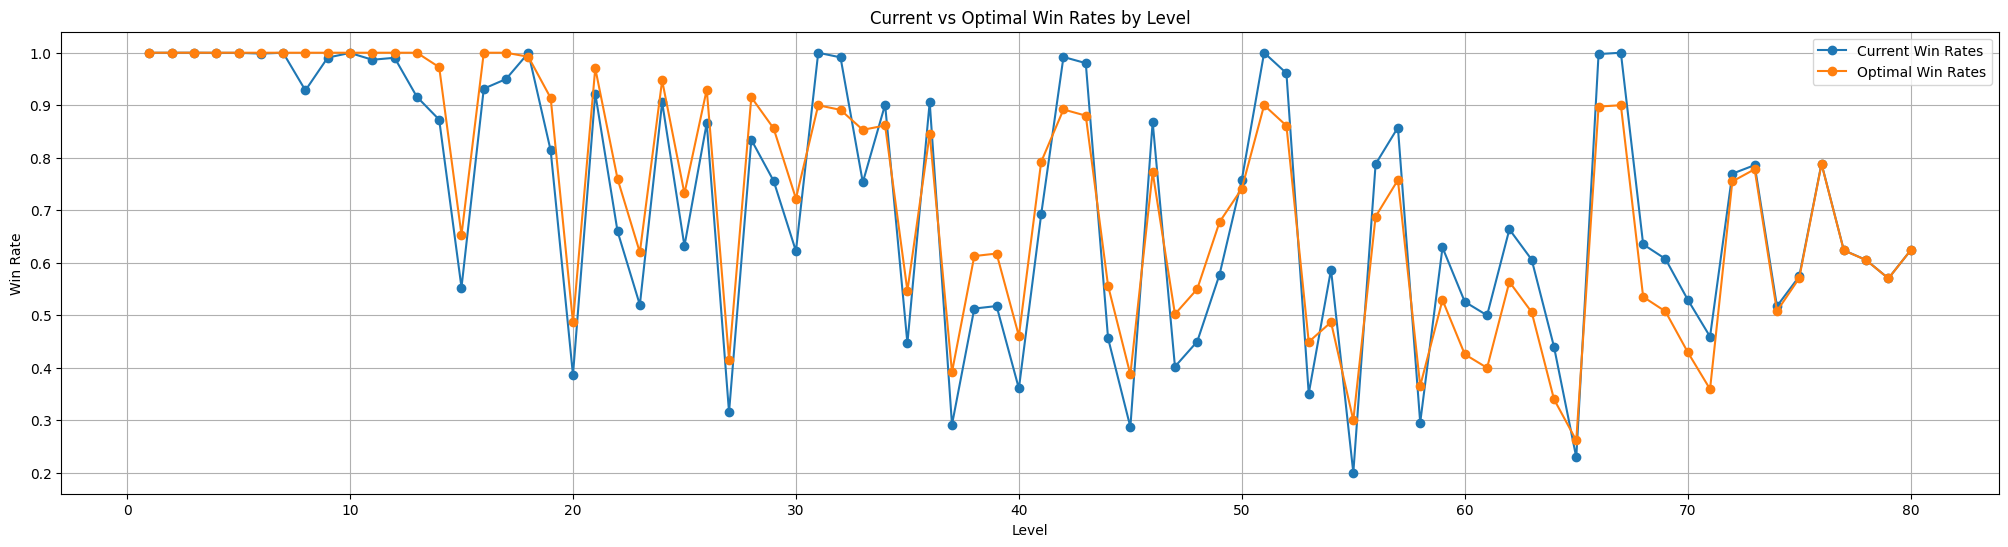

In [ ]:
# prompt: optimal_win_rates: Draw line chart for these value

plt.figure(figsize=(25, 6))
plt.plot(df_train['level'], df_train['winrate'], 'o-', label='Current Win Rates')
plt.plot(df_train['level'], optimal_win_rates, 'o-', label='Optimal Win Rates')
plt.xlabel('Level')
plt.ylabel('Win Rate')
plt.title('Current vs Optimal Win Rates by Level')
plt.legend()
plt.grid(True)
plt.show()